# PATTERN RECOGNITION COURSEWORK 2
## REPRESENTATION AND DISTANCE METRIC LEARNING

In [1]:
# Imports
from scipy.io import loadmat
from scipy import stats
import json
import numpy as np
import random
from metric_learn.lmnn import LMNN
from metric_learn.covariance import Covariance
from metric_learn.mlkr import MLKR
from sklearn.neighbors import NearestNeighbors
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Set a random see so that results are replicable
random.seed(9999999)

### Data Preparation

In [2]:
# Access raw data from files
train_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['train_idx'].flatten()-1
query_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['query_idx'].flatten()-1
gallery_idxs = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['gallery_idx'].flatten()-1
labels = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['labels'].flatten()
camId = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['camId'].flatten()
filelist = loadmat('PR_data/cuhk03_new_protocol_config_labeled.mat')['filelist'].flatten()
with open('PR_data/feature_data.json','r') as f:
    features = json.load(f)
features = np.array(features) # rows: pictures, columns: features (one row contains one image)

In [3]:
# Create the usable data sets from the given indices
train_feat = features[train_idxs,:]
train_labels = labels[train_idxs]
train_camId = camId[train_idxs]
train_filelist = filelist[train_idxs]
query_feat = features[query_idxs,:]
query_labels = labels[query_idxs]
query_camId = camId[query_idxs]
query_filelist = filelist[query_idxs]
gallery_feat = features[gallery_idxs,:]
gallery_labels = labels[gallery_idxs]
gallery_camId = camId[gallery_idxs]
gallery_filelist = filelist[gallery_idxs]

In [4]:
# Create a validation set
unique_id_train = np.unique(train_labels) #find all unique training IDs
unique_id_val = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),100))] # pick 100 random unique training IDs
bool_idx_val = np.isin(train_labels, unique_id_val)
bool_idx_train_noval = np.isin(train_labels, unique_id_val, invert=True)

train_noval_feat = train_feat[bool_idx_train_noval,:]
train_noval_labels = train_labels[bool_idx_train_noval]
train_noval_camId = train_camId[bool_idx_train_noval]
train_noval_filelist = train_filelist[bool_idx_train_noval]

val_feat = train_feat[bool_idx_val,:]
val_labels = train_labels[bool_idx_val]
val_camId = train_camId[bool_idx_val]
val_filelist = train_filelist[bool_idx_val]

<b> Validation Query and Gallery set: </b> <br>
Make sure that the query and gallery for validation are similarly structured as the gallery and query set for testing (i.e. take one picture from each camera and person for the query set - only valid if that sample has at least one complementary image from the other camera in the gallery set)

In [5]:
# Create gallery and query set for validation
val_label_cam_pair = np.append(val_labels.reshape((1,val_labels.shape[0])),val_camId.reshape((1,val_camId.shape[0])),axis=0)
val_pair_unique, val_pair_unique_indxs = np.unique(val_label_cam_pair, axis=1, return_index=True)

val_query_feat = val_feat[val_pair_unique_indxs,:]
val_query_labels = val_labels[val_pair_unique_indxs]
val_query_camId = val_camId[val_pair_unique_indxs]

val_gallery_feat = np.delete(val_feat, val_pair_unique_indxs, axis = 0)
val_gallery_labels = np.delete(val_labels, val_pair_unique_indxs)
val_gallery_camId = np.delete(val_camId, val_pair_unique_indxs)

idxs_delete = []
for i in range(val_query_labels.shape[0]):
    g_camId = val_gallery_camId[val_gallery_labels==val_query_labels[i]]
    if (val_query_camId[i]==1 and (2 not in g_camId)) or (val_query_camId[i]==2 and (1 not in g_camId)):
        val_gallery_feat = np.append(val_gallery_feat, val_query_feat[[i],:],axis=0)
        val_gallery_labels = np.append(val_gallery_labels, val_query_labels[i])
        val_gallery_camId = np.append(val_gallery_camId, val_query_camId[i])
        idxs_delete.append(i)

val_query_feat = np.delete(val_query_feat, idxs_delete, axis = 0)
val_query_labels = np.delete(val_query_labels, idxs_delete)
val_query_camId = np.delete(val_query_camId, idxs_delete)

### Create Printing and Evaluation functions

<b> Function for printing the ranklists of a query image </b>

In [6]:
def printranklist (queryid, nn_idx, is_same):
    plt.figure(figsize=(10, 30))
    plt.subplot(1,11,1)
    plt.xticks([])
    plt.yticks([])
    img = Image.open('PR_data/images_cuhk03/'+query_filelist[queryid].item(0))
    img_resized = img.resize((150, 400), Image.ANTIALIAS)
    img_with_border = ImageOps.expand(img_resized,border=15,fill='black')
    plt.imshow(img_with_border)

    for i in range (2, 12, 1):
        plt.subplot (1, 11, i)
        plt.xticks([])
        plt.yticks([])
        img = Image.open('PR_data/images_cuhk03/'+gallery_filelist[nn_idx[i-2]].item(0))
        img_resized = img.resize((150, 400), Image.ANTIALIAS)
        if (is_same[i-2]==True):
            fillcolour = 'green'
        else:
            fillcolour = 'red'
        img_with_border = ImageOps.expand(img_resized,border=15,fill=fillcolour)
        plt.imshow(img_with_border)
    plt.show()
    print("The ranklist for the {}th query image".format(queryid))
    return

<b> Evaluation function for testing </b>

In [7]:
def kNN (t_query_feat, t_gallery_feat):
    # k nearest neighbours implementation
    k = 10
    top_k_rank = np.zeros((query_labels.shape[0],k))
    top_k_precision = np.zeros((query_labels.shape[0],k))
    top_k_recall = np.zeros((query_labels.shape[0],k))

    nbrs = NearestNeighbors(n_neighbors=20).fit(t_gallery_feat)
    distances, indices = nbrs.kneighbors(t_query_feat)
    
    # Indices contains indices of the closes gallery pictures to each query image

    # Select the images where camId and label not the same as of the query image
    # Take top k of them

    for i in range (0, query_labels.shape[0], 1):
        selected_indices = np.logical_not(np.logical_and(gallery_camId[indices[i, :]] == query_camId[i], gallery_labels[indices[i,:]] == query_labels[i]))
        number_of_removed = np.sum(np.logical_and(gallery_camId == query_camId[i], gallery_labels == query_labels[i]))
        removed_indices = indices [i, selected_indices]
        is_same_label = (query_labels[i] == gallery_labels[removed_indices])
        if (i == 3 or i ==133):
            printranklist (i, removed_indices, is_same_label)
        for j in range (0, k, 1):
            top_k_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
            top_k_precision[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
            top_k_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(gallery_labels==query_labels[i])-number_of_removed)
    
    # print CMC curve
    print("Drawing the CMC curve of the model")
    plt.figure()
    x = range(k+1, 1, -1)
    cmc = top_k_precision.mean(axis=0)
    plt.plot(x, cmc)
    plt.title('CMC Curve')
    plt.ylabel('Cumulative Matching Charactersitic')
    plt.xlabel('Rank')
    plt.show()
    
    # calculate mAP
    average_precisions = np.zeros((query_labels.shape))
    for j in range (0, query_labels.shape[0], 1):
        recall = top_k_recall[j, :]
        precision = top_k_precision[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)
    
    # kmeans clustering evaluation method
    kmeans = KMeans(n_clusters=((np.unique(gallery_labels)).shape[0]), n_init=1, max_iter=10, random_state=0, precompute_distances= True).fit(t_gallery_feat)
    k_means_predictions = kmeans.predict(t_query_feat)
    label_mapping = np.zeros((np.unique(kmeans.labels_).shape))
    for i in np.unique(kmeans.labels_):
        selected_gallery = gallery_labels[kmeans.labels_==i]
        elements, counts = np.unique(selected_gallery, return_counts = True)
        majority = elements[np.argmax(counts)]
        label_mapping[i] = majority
    predictions_mapped = np.zeros((k_means_predictions.shape))
    for i in range (0, k_means_predictions.shape[0], 1):
        predictions_mapped[i] = label_mapping[k_means_predictions[i]]      
    
    
    # print results
    print("Mean average precision:", average_precisions.mean())
    print("Top1:", top_k_rank[:, 0].mean())
    print("Top5:", top_k_rank[:, 4].mean())
    print("Top10:", top_k_rank[:, 9].mean())
    print("Top5-Precision:", top_k_precision[:, 4].mean())
    print("Top5-Recall:", top_k_recall[:, 4].mean())
    print("Kmeans accuracy:", (np.sum(query_labels==predictions_mapped)/query_labels.shape).item(0))
    return

<b> Evaluation function for validation </b>

In [8]:
def kNN_val (t_query_feat, t_gallery_feat):
    # k nearest neighbours implementation
    k = 10
    top_k_rank = np.zeros((val_query_labels.shape[0],k))
    top_k_precision = np.zeros((val_query_labels.shape[0],k))
    top_k_recall = np.zeros((val_query_labels.shape[0],k))

    nbrs = NearestNeighbors(n_neighbors=20).fit(t_gallery_feat)
    distances, indices = nbrs.kneighbors(t_query_feat)
    # Indices contains indices of the closes gallery pictures to each query image

    # Select the images where camId and label not the same as of the query image
    # Take top k of them

    for i in range (0, val_query_labels.shape[0], 1):
        selected_indices = np.logical_not(np.logical_and(val_gallery_camId[indices[i, :]] == val_query_camId[i], val_gallery_labels[indices[i,:]] == val_query_labels[i]))
        number_of_removed = np.sum(np.logical_and(val_gallery_camId == val_query_camId[i], val_gallery_labels == val_query_labels[i]))
        removed_indices = indices [i, selected_indices]
        is_same_label = (val_query_labels[i] == val_gallery_labels[removed_indices])

        for j in range (0, k, 1):
            top_k_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
            top_k_precision[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
            top_k_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(val_gallery_labels==val_query_labels[i])-number_of_removed)

    # calculate mAP
    average_precisions = np.zeros((val_query_labels.shape))
    for j in range (0, val_query_labels.shape[0], 1):
        recall = top_k_recall[j, :]
        precision = top_k_precision[j, :]
        index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
        recall = recall[index]
        precision = precision[index]
        recall_range = np.arange(0, 1.1, 0.1)
        precision_range = np.zeros((recall_range.shape))
        for i in range (0, recall_range.shape[0], 1):    
            if (precision[recall>=recall_range[i]].size != 0):
                precision_range[i] = np.max(precision[recall>=recall_range[i]])
            else:     
                precision_range[i] = 0
        average_precisions[j] = np.mean(precision_range)  
    
    # print results
    print("Mean average precision:", average_precisions.mean())
    print("Top1:", top_k_rank[:, 0].mean())
    print("Top5:", top_k_rank[:, 4].mean())
    print("Top10:", top_k_rank[:, 9].mean())
    print("Top5-Precision:", top_k_precision[:, 4].mean())
    print("Top5-Recall:", top_k_recall[:, 4].mean())
    return

### BASELINE APPROACH

<b> Evaluation of original features </b>

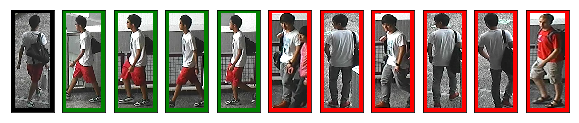

The ranklist for the 3th query image


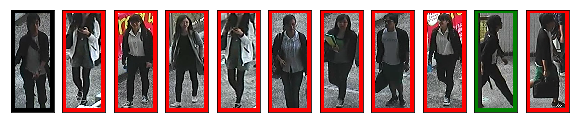

The ranklist for the 133th query image
Drawing the CMC curve of the model


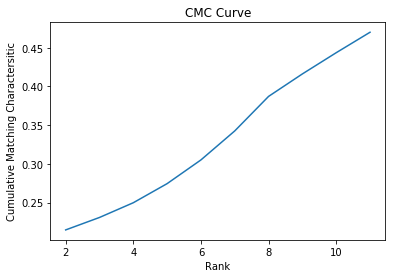

Mean average precision: 0.4353663677592249
Top1: 0.47
Top5: 0.6685714285714286
Top10: 0.7492857142857143
Top5-Precision: 0.3425714285714286
Top5-Recall: 0.4498214285714286
Kmeans accuracy: 0.7085714285714285


In [9]:
kNN(query_feat, gallery_feat)

<b> Evaluation of validation set with original features </b>

In [10]:
kNN_val(val_query_feat, val_gallery_feat)

Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


### Feature Reduction

<b> PCA </b> <br>
Plot the eigenvalues of the training set:

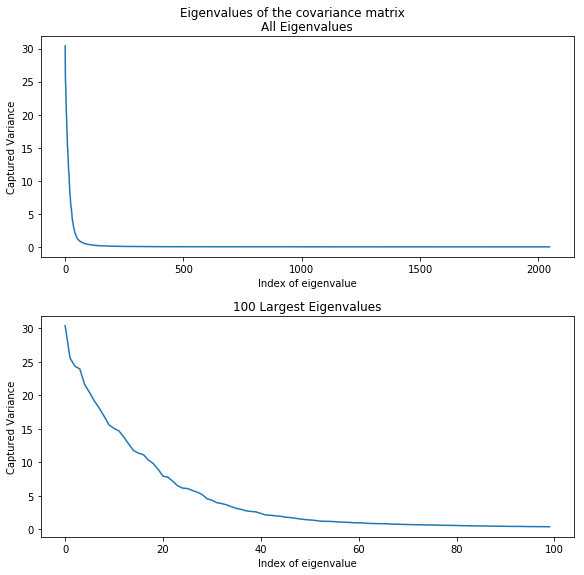

Percentage of total data variance captured by 500 largest eigenvectors: 0.9292050565369442
Percentage of total data variance captured by 500 largest eigenvectors: 0.9733843233063826
Percentage of total data variance captured by 500 largest eigenvectors: 0.9896934896951645


In [11]:
pca_train =PCA()
pca_train.fit(train_feat)
pca_train_eigvals = pca_train.explained_variance_

x = np.arange(0, pca_train_eigvals.shape[0])
fig, axs = plt.subplots(2, 1, constrained_layout = True, figsize = (8, 8))
axs[0].plot(x, pca_train_eigvals, '-')
axs[0].set_title('All Eigenvalues')
axs[0].set_xlabel("Index of eigenvalue")
axs[0].set_ylabel("Captured Variance")

fig.suptitle('Eigenvalues of the covariance matrix')
axs[1].plot(x[:100], pca_train_eigvals[:100], '-')
axs[1].set_title('100 Largest Eigenvalues')
axs[1].set_xlabel("Index of eigenvalue")
axs[1].set_ylabel("Captured Variance")
plt.show()

print("Percentage of total data variance captured by 500 largest eigenvectors:", 
      (np.sum(pca_train_eigvals[:100]))/(np.sum(pca_train_eigvals[:100])+np.sum(pca_train_eigvals[100:])))
print("Percentage of total data variance captured by 500 largest eigenvectors:", 
      (np.sum(pca_train_eigvals[:250]))/(np.sum(pca_train_eigvals[:250])+np.sum(pca_train_eigvals[250:])))
print("Percentage of total data variance captured by 500 largest eigenvectors:", 
      (np.sum(pca_train_eigvals[:500]))/(np.sum(pca_train_eigvals[:500])+np.sum(pca_train_eigvals[500:])))

Validate for reduced dimensions:

In [12]:
for i in [100, 250, 500]:
    pca_train_noval =PCA(n_components = i)
    pca_train_noval.fit(train_noval_feat)
    print("\nPCA with {} dimensions:".format(i))
    kNN_val(pca_train_noval.transform(val_query_feat), pca_train_noval.transform(val_gallery_feat))


PCA with 100 dimensions:
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

PCA with 250 dimensions:
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

PCA with 500 dimensions:
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


Evaluate PCA feature transform on test set:


PCA with 100 dimensions:


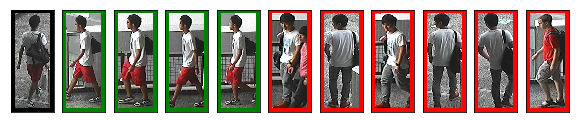

The ranklist for the 3th query image


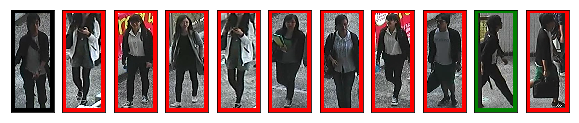

The ranklist for the 133th query image
Drawing the CMC curve of the model


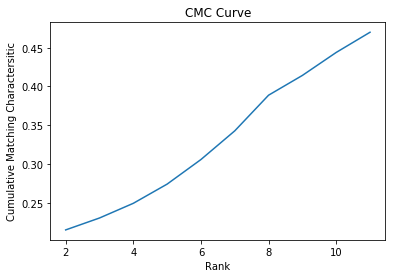

Mean average precision: 0.43498268398268397
Top1: 0.47
Top5: 0.6771428571428572
Top10: 0.7485714285714286
Top5-Precision: 0.34271428571428575
Top5-Recall: 0.45017857142857143
Kmeans accuracy: 0.7292857142857143

PCA with 250 dimensions:


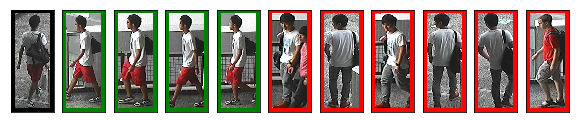

The ranklist for the 3th query image


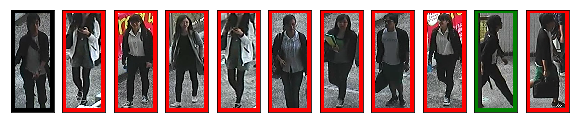

The ranklist for the 133th query image
Drawing the CMC curve of the model


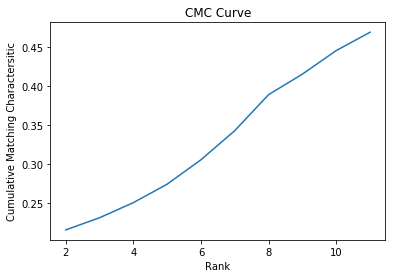

Mean average precision: 0.4358255256648114
Top1: 0.4692857142857143
Top5: 0.6728571428571428
Top10: 0.7492857142857143
Top5-Precision: 0.3428571428571429
Top5-Recall: 0.4511309523809523
Kmeans accuracy: 0.7185714285714285

PCA with 500 dimensions:


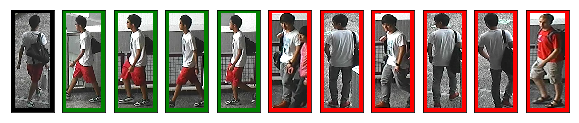

The ranklist for the 3th query image


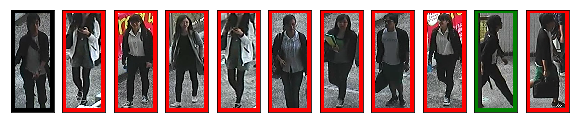

The ranklist for the 133th query image
Drawing the CMC curve of the model


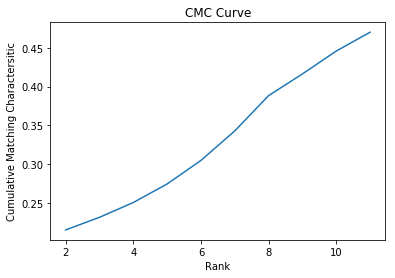

Mean average precision: 0.4357548701298702
Top1: 0.47
Top5: 0.6707142857142857
Top10: 0.7492857142857143
Top5-Precision: 0.34271428571428575
Top5-Recall: 0.45077380952380947
Kmeans accuracy: 0.7228571428571429


In [13]:
for i in [100, 250, 500]:
    pca_train = PCA(n_components=i)
    pca_train.fit(train_feat)
    print("\nPCA with {} dimensions:".format(i))
    kNN(pca_train.transform(query_feat), pca_train.transform(gallery_feat))

FINAL PCA TRANSFORMATIONS - USED IN THE CODE LATER:

In [14]:
pca = PCA(n_components = 500)
train_feat_PCA_500 = pca.fit_transform(train_feat)
query_feat_PCA_500 = pca.transform(query_feat)
gallery_feat_PCA_500 = pca.transform(gallery_feat)
train_noval_feat_PCA_500 = pca.fit_transform(train_noval_feat)
val_query_feat_PCA_500 = pca.transform(val_query_feat)
val_gallery_feat_PCA_500 = pca.transform(val_gallery_feat)

pca = PCA(n_components = 50)
train_feat_PCA_50 = pca.fit_transform(train_feat)
query_feat_PCA_50 = pca.transform(query_feat)
gallery_feat_PCA_50 = pca.transform(gallery_feat)
train_noval_feat_PCA_50 = pca.fit_transform(train_noval_feat)
val_query_feat_PCA_50 = pca.transform(val_query_feat)
val_gallery_feat_PCA_50 = pca.transform(val_gallery_feat)

<b> LDA

Validate for reduced dimensions:

In [15]:
for i in [50, 100, 250, 500]:
    lda_train_noval =LinearDiscriminantAnalysis(n_components = i)
    lda_train_noval.fit(train_noval_feat, train_noval_labels)
    print("\nLDA with {} dimensions:".format(i))
    kNN_val(lda_train_noval.transform(val_query_feat), lda_train_noval.transform(val_gallery_feat))


LDA with 50 dimensions:
Mean average precision: 0.9839674563292653
Top1: 0.9949748743718593
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7437185929648241
Top5-Recall: 0.9861809045226131

LDA with 100 dimensions:
Mean average precision: 0.9970077661032434
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7517587939698491
Top5-Recall: 0.9962311557788944

LDA with 250 dimensions:
Mean average precision: 0.9985076899649763
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7527638190954772
Top5-Recall: 0.9974874371859297

LDA with 500 dimensions:
Mean average precision: 0.99945180447693
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


Evaluate LDA feature transform on test set:


LDA with 50 dimensions:


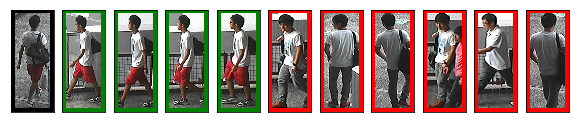

The ranklist for the 3th query image


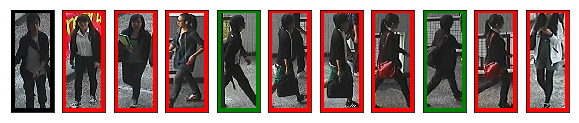

The ranklist for the 133th query image
Drawing the CMC curve of the model


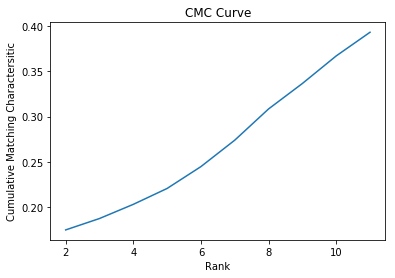

Mean average precision: 0.3436014996907854
Top1: 0.39285714285714285
Top5: 0.5771428571428572
Top10: 0.665
Top5-Precision: 0.274
Top5-Recall: 0.35892857142857143
Kmeans accuracy: 0.6564285714285715

LDA with 100 dimensions:


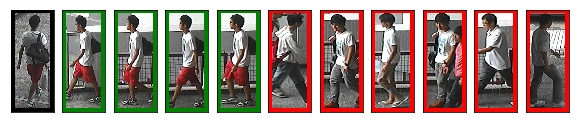

The ranklist for the 3th query image


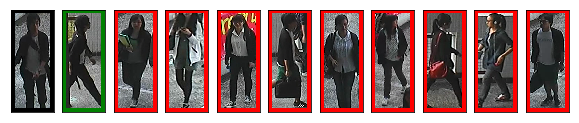

The ranklist for the 133th query image
Drawing the CMC curve of the model


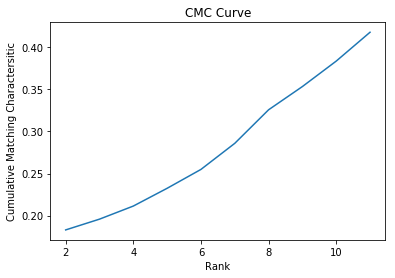

Mean average precision: 0.36187585034013603
Top1: 0.41785714285714287
Top5: 0.6007142857142858
Top10: 0.6935714285714286
Top5-Precision: 0.28585714285714287
Top5-Recall: 0.37464285714285717
Kmeans accuracy: 0.6642857142857143

LDA with 250 dimensions:


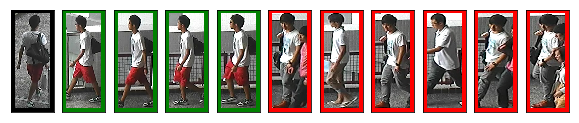

The ranklist for the 3th query image


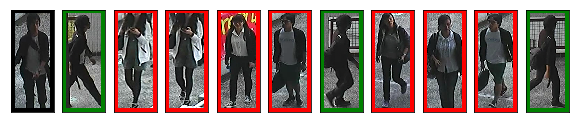

The ranklist for the 133th query image
Drawing the CMC curve of the model


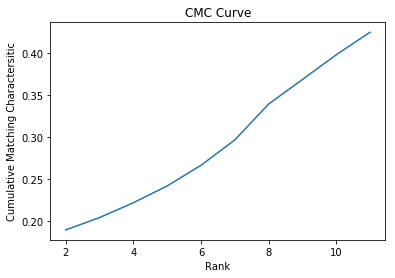

Mean average precision: 0.3757265254586683
Top1: 0.42428571428571427
Top5: 0.6221428571428571
Top10: 0.7128571428571429
Top5-Precision: 0.2962857142857143
Top5-Recall: 0.3884523809523809
Kmeans accuracy: 0.67

LDA with 500 dimensions:


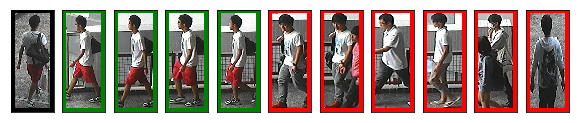

The ranklist for the 3th query image


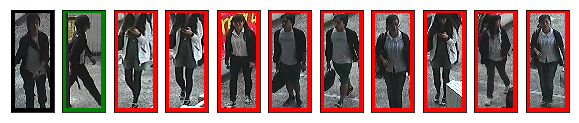

The ranklist for the 133th query image
Drawing the CMC curve of the model


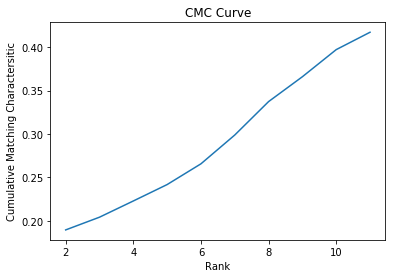

Mean average precision: 0.3745382395382395
Top1: 0.41714285714285715
Top5: 0.6221428571428571
Top10: 0.7142857142857143
Top5-Precision: 0.2988571428571428
Top5-Recall: 0.39220238095238097
Kmeans accuracy: 0.6864285714285714


In [16]:
for i in [50, 100, 250, 500]:
    lda_train = LinearDiscriminantAnalysis(n_components=i)
    lda_train.fit(train_feat, train_labels)
    print("\nLDA with {} dimensions:".format(i))
    kNN(lda_train.transform(query_feat), lda_train.transform(gallery_feat))

FINAL LDA TRANSFORMATION:

In [17]:
lda = LinearDiscriminantAnalysis(n_components = 500)
train_feat_LDA = lda.fit_transform(train_feat, train_labels)
query_feat_LDA = lda.transform(query_feat)
gallery_feat_LDA = lda.transform(gallery_feat)
train_noval_feat_LDA = lda.fit_transform(train_noval_feat, train_noval_labels)
val_query_feat_LDA = lda.transform(val_query_feat)
val_gallery_feat_LDA = lda.transform(val_gallery_feat)

### MAHALANOBIS DISTANCE LEARNING

<b> Original covariance based approach </b>

Validation on all dimension:

In [18]:
Cov_Model_val = Covariance().fit(train_noval_feat, train_noval_labels)
val_query_feat_Cov = Cov_Model_val.transform(val_query_feat)
val_gallery_feat_Cov = Cov_Model_val.transform(val_gallery_feat)
kNN_val(val_query_feat_Cov, val_gallery_feat_Cov)

Mean average precision: 0.979396984924623
Top1: 0.9949748743718593
Top5: 0.9949748743718593
Top10: 1.0
Top5-Precision: 0.7386934673366833
Top5-Recall: 0.9761306532663316


Validation on reduced dimensions:

In [19]:
for i in [50, 100, 250, 500]:
    print("\nPCA-COV with {} dimensions:".format(i))
    pca_train_noval = PCA(n_components=i)
    train_noval_feat_PCA_t = pca_train_noval.fit_transform(train_noval_feat)
    val_query_feat_PCA_t = pca_train_noval.transform(val_query_feat) 
    val_gallery_feat_PCA_t = pca_train_noval.transform(val_gallery_feat)
    Cov_Model_val = Covariance().fit(train_noval_feat_PCA_t, train_noval_labels)
    val_query_feat_Cov_PCA = Cov_Model_val.transform(val_query_feat_PCA_t)
    val_gallery_feat_Cov_PCA = Cov_Model_val.transform(val_gallery_feat_PCA_t)
    kNN_val(val_query_feat_Cov_PCA, val_gallery_feat_Cov_PCA)
    
    print("\nLDA-COV with {} dimensions:".format(i))
    lda_train_noval = LinearDiscriminantAnalysis(n_components=i)
    train_noval_feat_LDA_t = lda_train_noval.fit_transform(train_noval_feat, train_noval_labels)
    val_query_feat_LDA_t = lda_train_noval.transform(val_query_feat) 
    val_gallery_feat_LDA_t = lda_train_noval.transform(val_gallery_feat)
    Cov_Model_val = Covariance().fit(train_noval_feat_LDA_t, train_noval_labels)
    val_query_feat_Cov_LDA = Cov_Model_val.transform(val_query_feat_LDA_t)
    val_gallery_feat_Cov_LDA = Cov_Model_val.transform(val_gallery_feat_LDA_t)
    kNN_val(val_query_feat_Cov_LDA, val_gallery_feat_Cov_LDA)


PCA-COV with 50 dimensions:
Mean average precision: 0.9992690726359068
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

LDA-COV with 50 dimensions:
Mean average precision: 0.9747123061193412
Top1: 0.9849246231155779
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7396984924623115
Top5-Recall: 0.9811557788944724

PCA-COV with 100 dimensions:
Mean average precision: 0.999725902238465
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0

LDA-COV with 100 dimensions:
Mean average precision: 0.9948073701842546
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7497487437185929
Top5-Recall: 0.9937185929648241

PCA-COV with 250 dimensions:
Mean average precision: 0.9995431703974418
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7537688442211053
Top5-Recall: 0.9987437185929648

LDA-COV with 250 dimensions:
Mean average precision: 0.9946811981987861
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7497487437185929
Top5-Recall: 0.993718592

Test on all dimension:

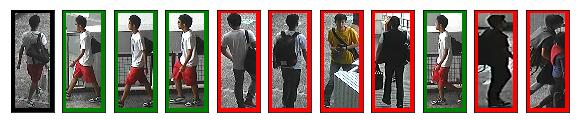

The ranklist for the 3th query image


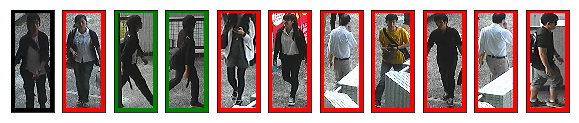

The ranklist for the 133th query image
Drawing the CMC curve of the model


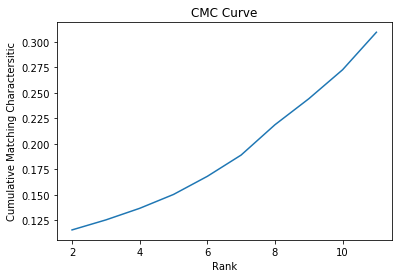

Mean average precision: 0.2337029220779221
Top1: 0.3092857142857143
Top5: 0.455
Top10: 0.5014285714285714
Top5-Precision: 0.18885714285714283
Top5-Recall: 0.2478571428571428
Kmeans accuracy: 0.5914285714285714


In [20]:
Cov_Model = Covariance().fit(train_feat, train_labels)
query_feat_Cov = Cov_Model.transform(query_feat)
gallery_feat_Cov = Cov_Model.transform(gallery_feat)
kNN(query_feat_Cov, gallery_feat_Cov)

Test on reduced dimensions (PCA-50-dimensions):

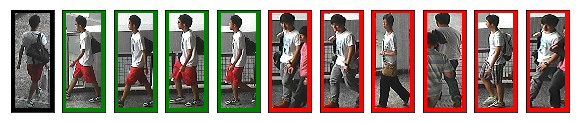

The ranklist for the 3th query image


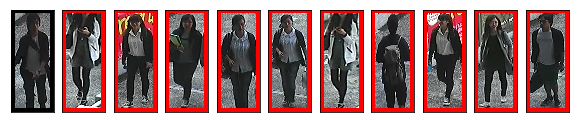

The ranklist for the 133th query image
Drawing the CMC curve of the model


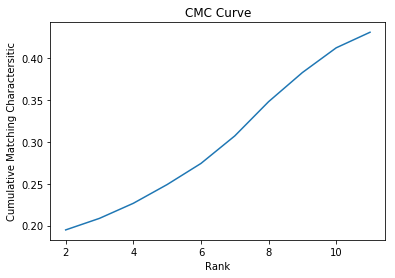

Mean average precision: 0.3901904761904762
Top1: 0.4307142857142857
Top5: 0.6378571428571429
Top10: 0.7114285714285714
Top5-Precision: 0.307
Top5-Recall: 0.4027380952380952
Kmeans accuracy: 0.6964285714285714


In [21]:
Cov_Model = Covariance().fit(train_feat_PCA_50, train_labels)
query_feat_Cov_PCA = Cov_Model.transform(query_feat_PCA_50)
gallery_feat_Cov_PCA = Cov_Model.transform(gallery_feat_PCA_50)
kNN(query_feat_Cov_PCA, gallery_feat_Cov_PCA)

<b> Large Margin Nearest Neighbours 

Validation on all dimension:

In [22]:
LargeMarg_Model = LMNN(verbose=True).fit(train_noval_feat,train_noval_labels)
val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat)
val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat)
kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 666804.1259610604 -2147.849232827779 28 1.0099999999999999e-07
3 664640.7680087306 -2163.357952329796 28 1.0201e-07
4 662462.6542554984 -2178.1137532321736 27 1.030301e-07
5 660270.1987222336 -2192.455533264787 26 1.0406040099999999e-07
6 658063.7577313259 -2206.440990907722 25 1.0510100500999999e-07
7 655843.3231152626 -2220.4346160633722 24 1.0615201506009999e-07
8 653608.0213789083 -2235.301736354246 24 1.0721353521070098e-07
9 651358.1726054724 -2249.8487734359223 22 1.08285670562808e-07
10 649095.1326539797 -2263.039951492683 21 1.0936852726843608e-07
11 646817.7857846182 -2277.3468693614705 20 1.1046221254112044e-07
12 644525.2382062408 -2292.5475783774164 19 1.1156683466653164e-07
13 642218.5739420471 -2306.664264193736 19 1.1268250301319696e-07
14 639896.1609452836 -2322.41299676348 19 1.1380932804332893e-07
15 637557.9888186157 -2338.1721266679233 19 1.1494742132376222e-07
16 635204.0500172463 -2353.938801369397 19 1.1609689553699984e-07
17 632834.3631787028 -2369.6868385435

128 313392.8659080552 -2401.0625803959556 0 3.538461465303104e-07
129 311038.7069120227 -2354.1589960324927 0 3.573846079956135e-07
130 308733.3459118217 -2305.3610002010246 0 3.6095845407556966e-07
131 306478.72491308476 -2254.6209987369366 0 3.645680386163254e-07
132 304276.83456741786 -2201.890345666907 0 3.6821371900248867e-07
133 302129.7152462979 -2147.1193211199716 0 3.7189585619251353e-07
134 300039.4581375245 -2090.257108773396 0 3.7561481475443865e-07
135 298008.2063646719 -2031.2517728526145 0 3.7937096290198303e-07
136 296038.1561300304 -1970.0502346414723 0 3.8316467253100284e-07
137 294131.5578815067 -1906.5982485237182 0 3.8699631925631286e-07
138 292290.7175039797 -1840.840377526998 0 3.9086628244887597e-07
139 290517.9975356149 -1772.7199683648068 0 3.947749452733647e-07
140 288815.81840964383 -1702.1791259710444 0 3.987226947260984e-07
141 287186.6597221361 -1629.1586875077337 0 4.027099216733594e-07
142 285633.06152629346 -1553.5981958426419 0 4.0673702089009297e-07


Validation on reduced dimensions - PCA:

In [23]:
LargeMarg_Model = LMNN(verbose=True).fit(train_noval_feat_PCA_50,train_noval_labels)
val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat_PCA_50)
val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat_PCA_50)
print("PCA-LMNN with 50 dimensions:")
kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)

LargeMarg_Model = LMNN(verbose=True).fit(train_noval_feat_PCA_500,train_noval_labels)
val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat_PCA_500)
val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat_PCA_500)
print("PCA-LMNN with 500 dimensions:")
kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 426227.99006661994 -1985.6802866519429 46 1.0099999999999999e-07
3 424232.03364215256 -1995.956424467382 46 1.0201e-07
4 422221.89898712386 -2010.134655028698 46 1.030301e-07
5 420197.87601613626 -2024.0229709876003 45 1.0406040099999999e-07
6 418161.603503768 -2036.2725123682758 44 1.0510100500999999e-07
7 416112.0637510503 -2049.539752717712 44 1.0615201506009999e-07
8 414048.61126185267 -2063.4524891976034 43 1.0721353521070098e-07
9 411973.5166547755 -2075.0946070771897 40 1.08285670562808e-07
10 409887.24635352363 -2086.270301251847 38 1.0936852726843608e-07
11 407788.54522206355 -2098.7011314600823 38 1.1046221254112044e-07
12 405676.68001552403 -2111.8652065395145 36 1.1156683466653164e-07
13 403552.72207021085 -2123.9579453131882 35 1.1268250301319696e-07
14 401415.0773467217 -2137.644723489124 34 1.1380932804332893e-07
15 399264.1760842043 -2150.9012625174364 34 1.1494742132376222e-07
16 397098.9264755314 -2165.2496086728643 34 1.1609689553699984e-07
17 394919.3289666375 -21

140 82026.29753636847 -1506.0314533612545 2 3.987226947260984e-07
141 80588.14319793144 -1438.1543384370307 2 4.027099216733594e-07
142 79220.21178789996 -1367.9314100314805 2 4.0673702089009297e-07
143 77925.25114878066 -1294.9606391192938 3 4.108043910989939e-07
144 76705.86809008221 -1219.383058698455 3 4.1491243500998386e-07
145 75564.45701448954 -1141.4110755926667 5 4.190615593600837e-07
146 74504.45970093948 -1059.9973135500622 5 4.2325217495368454e-07
147 73527.48779381196 -976.9719071275176 5 4.2748469670322137e-07
148 72636.29367616794 -891.1941176440159 6 4.317595436702536e-07
149 71834.45162784617 -801.8420483217778 8 4.3607713910695614e-07
150 71125.41429397918 -709.0373338669888 8 4.404379104980257e-07
151 70510.88347187321 -614.5308221059677 9 4.44842289603006e-07
152 69994.69129796358 -516.1921739096288 9 4.4929071249903604e-07
153 69579.1183015432 -415.57299642037833 9 4.537836196240264e-07
154 69268.49120488839 -310.62709665481816 10 4.583214558202667e-07
155 69069.31

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 609194.0260053151 -2128.989158987184 28 1.0099999999999999e-07
3 607049.6522549577 -2144.373750357423 28 1.0201e-07
4 604890.4599247689 -2159.1923301888164 27 1.030301e-07
5 602716.7391398649 -2173.7207849039696 27 1.0406040099999999e-07
6 600528.1077495195 -2188.6313903453993 26 1.0510100500999999e-07
7 598325.7557576778 -2202.351991841686 24 1.0615201506009999e-07
8 596109.8388406067 -2215.9169170710957 24 1.0721353521070098e-07
9 593878.9448104255 -2230.8940301812254 23 1.08285670562808e-07
10 591634.3251466232 -2244.619663802325 22 1.0936852726843608e-07
11 589374.8866068673 -2259.43853975588 22 1.1046221254112044e-07
12 587100.7296750388 -2274.1569318284746 20 1.1156683466653164e-07
13 584812.4638179668 -2288.2658570720814 19 1.1268250301319696e-07
14 582509.91094876 -2302.55286920676 19 1.1380932804332893e-07
15 580191.7186920247 -2318.1922567352885 19 1.1494742132376222e-07
16 577857.8791153233 -2333.839576701401 19 1.1609689553699984e-07
17 575508.3871909683 -2349.49192435503

130 253769.02663545177 -2295.826373503718 0 3.6095845407556966e-07
131 251523.26730896375 -2245.7593264880124 0 3.645680386163254e-07
132 249329.54350870723 -2193.723800256528 0 3.6821371900248867e-07
133 247189.87290164665 -2139.6706070605724 0 3.7189585619251353e-07
134 245106.32342738096 -2083.5494742656883 0 3.7561481475443865e-07
135 243081.01440579945 -2025.3090215815173 0 3.7937096290198303e-07
136 241116.11766797217 -1964.8967378272791 0 3.8316467253100284e-07
137 239213.85871075338 -1902.2589572187862 0 3.8699631925631286e-07
138 237376.51787558376 -1837.340835169627 0 3.9086628244887597e-07
139 235606.43155198742 -1770.0863235963334 0 3.947749452733647e-07
140 233905.99340627054 -1700.4381457168784 0 3.987226947260984e-07
141 232277.65563593828 -1628.3377703322622 0 4.027099216733594e-07
142 230723.93025035717 -1553.725385581114 0 4.0673702089009297e-07
143 229247.3903781998 -1476.5398721573583 0 4.108043910989939e-07
144 227850.67160222298 -1396.7187759768276 0 4.14912435009

Validation on number of k:

In [24]:
for k in [3,5]:
    LargeMarg_Model = LMNN(verbose=True, k=k).fit(train_noval_feat_PCA_50,train_noval_labels)
    val_query_feat_LMNN = LargeMarg_Model.transform(val_query_feat_PCA_50)
    val_gallery_feat_LMNN = LargeMarg_Model.transform(val_gallery_feat_PCA_50)
    print("PCA-LMNN with 50 dimensions and k={}:".format(k))
    kNN_val(val_query_feat_LMNN,val_gallery_feat_LMNN)


/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 426227.99006661994 -1985.6802866519429 46 1.0099999999999999e-07
3 424232.03364215256 -1995.956424467382 46 1.0201e-07
4 422221.89898712386 -2010.134655028698 46 1.030301e-07
5 420197.87601613626 -2024.0229709876003 45 1.0406040099999999e-07
6 418161.603503768 -2036.2725123682758 44 1.0510100500999999e-07
7 416112.0637510503 -2049.539752717712 44 1.0615201506009999e-07
8 414048.61126185267 -2063.4524891976034 43 1.0721353521070098e-07
9 411973.5166547755 -2075.0946070771897 40 1.08285670562808e-07
10 409887.24635352363 -2086.270301251847 38 1.0936852726843608e-07
11 407788.54522206355 -2098.7011314600823 38 1.1046221254112044e-07
12 405676.68001552403 -2111.8652065395145 36 1.1156683466653164e-07
13 403552.72207021085 -2123.9579453131882 35 1.1268250301319696e-07
14 401415.0773467217 -2137.644723489124 34 1.1380932804332893e-07
15 399264.1760842043 -2150.9012625174364 34 1.1494742132376222e-07
16 397098.9264755314 -2165.2496086728643 34 1.1609689553699984e-07
17 394919.3289666375 -21

128 103961.14942198351 -2156.7291575254494 2 3.538461465303104e-07
129 101848.1716830194 -2112.9777389641094 2 3.573846079956135e-07
130 99780.69578287596 -2067.475900143443 2 3.6095845407556966e-07
131 97760.5160354272 -2020.1797474487685 2 3.645680386163254e-07
132 95789.47161752521 -1971.0444179019833 2 3.6821371900248867e-07
133 93869.44755871859 -1920.0240588066226 2 3.7189585619251353e-07
134 92002.37575174402 -1867.0718069745635 2 3.7561481475443865e-07
135 90190.23598421758 -1812.1397675264452 2 3.7937096290198303e-07
136 88435.05699195978 -1755.1789922578027 2 3.8316467253100284e-07
137 86738.91753439952 -1696.1394575602608 2 3.8699631925631286e-07
138 85103.94749250861 -1634.9700418909051 2 3.9086628244887597e-07
139 83532.32898972972 -1571.6185027788888 2 3.947749452733647e-07
140 82026.29753636847 -1506.0314533612545 2 3.987226947260984e-07
141 80588.14319793144 -1438.1543384370307 2 4.027099216733594e-07
142 79220.21178789996 -1367.9314100314805 2 4.0673702089009297e-07
14

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


2 910544.0604176142 -10164.297883762629 289 1.0099999999999999e-07
3 900578.6575693777 -9965.402848236496 262 1.0201e-07
4 890750.4160992678 -9828.241470109904 250 1.030301e-07
5 880962.8884501492 -9787.527649118565 237 1.0406040099999999e-07
6 871214.5927747048 -9748.295675444417 221 1.0510100500999999e-07
7 861535.2886727749 -9679.304101929883 203 1.0615201506009999e-07
8 851909.8979231818 -9625.390749593149 188 1.0721353521070098e-07
9 842326.9375926973 -9582.960330484435 172 1.08285670562808e-07
10 832783.5926911407 -9543.344901556615 156 1.0936852726843608e-07
11 823277.7792343841 -9505.813456756645 145 1.1046221254112044e-07
12 813787.4619697303 -9490.317264653742 137 1.1156683466653164e-07
13 804297.1264794138 -9490.335490316502 126 1.1268250301319696e-07
14 794813.9415267442 -9483.18495266966 118 1.1380932804332893e-07
15 785332.4297195114 -9481.511807232746 112 1.1494742132376222e-07
16 775845.0097561318 -9487.419963379623 109 1.1609689553699984e-07
17 766346.1459580121 -9498.

Test with reduced features - PCA 500 dimensions:

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


PCA-LMNN with 500 dimensions and k=3:


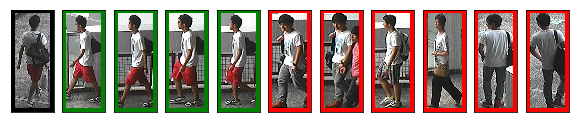

The ranklist for the 3th query image


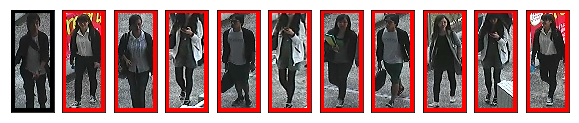

The ranklist for the 133th query image
Drawing the CMC curve of the model


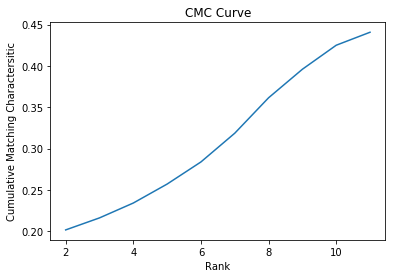

Mean average precision: 0.4045615594722738
Top1: 0.4407142857142857
Top5: 0.64
Top10: 0.7335714285714285
Top5-Precision: 0.31857142857142856
Top5-Recall: 0.41982142857142857
Kmeans accuracy: 0.7085714285714285


/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


PCA-LMNN with 500 dimensions and k=5:


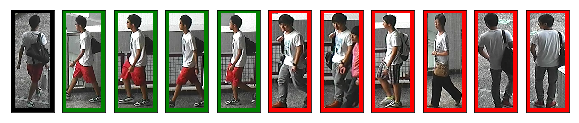

The ranklist for the 3th query image


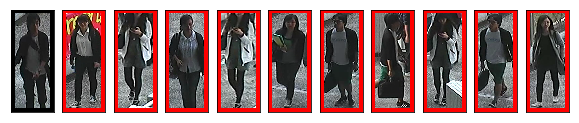

The ranklist for the 133th query image
Drawing the CMC curve of the model


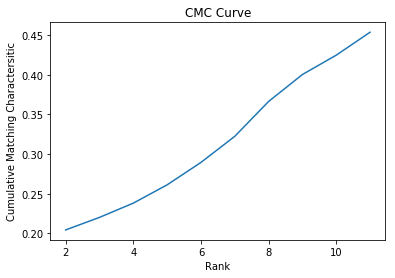

Mean average precision: 0.4111633426097712
Top1: 0.45357142857142857
Top5: 0.6592857142857143
Top10: 0.7364285714285714
Top5-Precision: 0.3222857142857143
Top5-Recall: 0.4245833333333333
Kmeans accuracy: 0.7192857142857143


In [25]:
for k in [3,5]:
    LargeMarg_Model = LMNN(k=k).fit(train_feat_PCA_500,train_labels)
    query_feat_LMNN = LargeMarg_Model.transform(query_feat_PCA_500)
    gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat_PCA_500)
    print("PCA-LMNN with 500 dimensions and k={}:".format(k))
    kNN(query_feat_LMNN,gallery_feat_LMNN)


Test  with original features

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/metric_learn/lmnn.py:62: UserWarning: use_pca does nothing for the python_LMNN implementation
  warnings.warn('use_pca does nothing for the python_LMNN implementation')


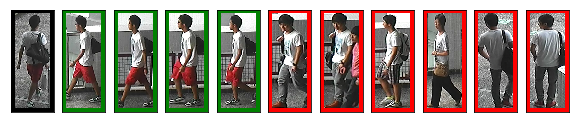

The ranklist for the 3th query image


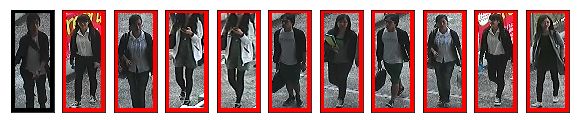

The ranklist for the 133th query image
Drawing the CMC curve of the model


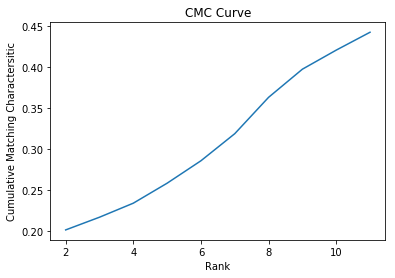

Mean average precision: 0.4047719800041228
Top1: 0.4421428571428571
Top5: 0.645
Top10: 0.7321428571428571
Top5-Precision: 0.31857142857142856
Top5-Recall: 0.4198809523809523
Kmeans accuracy: 0.7092857142857143


In [26]:
LargeMarg_Model = LMNN().fit(train_feat,train_labels)
query_feat_LMNN = LargeMarg_Model.transform(query_feat)
gallery_feat_LMNN = LargeMarg_Model.transform(gallery_feat)

kNN(query_feat_LMNN, gallery_feat_LMNN)

<b> Metric Learning for Kernel Regression

Validation on all dimension:

In [27]:
MLKR_Model = MLKR(verbose=True).fit(train_noval_feat,train_noval_labels)
val_query_feat_MLKR = MLKR_Model.transform(val_query_feat)
val_gallery_feat_MLKR = MLKR_Model.transform(val_gallery_feat)
kNN_val(val_query_feat_MLKR,val_gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      20.99
[MLKR] Training took    23.06s.
Mean average precision: 1.0
Top1: 1.0
Top5: 1.0
Top10: 1.0
Top5-Precision: 0.7547738693467336
Top5-Recall: 1.0


Validation on reduced dimensions - PCA:

In [28]:
MLKR_Model = MLKR(verbose=True).fit(train_noval_feat_PCA_50,train_noval_labels)
val_query_feat_MLKR = MLKR_Model.transform(val_query_feat_PCA_50)
val_gallery_feat_MLKR = MLKR_Model.transform(val_gallery_feat_PCA_50)
print("PCA-MLKR with 50 dimensions:")
kNN_val(val_query_feat_MLKR,val_gallery_feat_MLKR)

MLKR_Model = MLKR(verbose=True).fit(train_noval_feat_PCA_500,train_noval_labels)
val_query_feat_MLKR = MLKR_Model.transform(val_query_feat_PCA_500)
val_gallery_feat_MLKR = MLKR_Model.transform(val_gallery_feat_PCA_500)
print("PCA-MLKR with 500 dimensions:")
kNN_val(val_query_feat_MLKR,val_gallery_feat_MLKR)

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         1.915191e+03       4.76
[MLKR]          1         1.708116e+06       4.76
[MLKR]          2         1.121481e+06       4.86
[MLKR]          3         6.109137e+02       4.79
[MLKR]          4         1.118772e+06       4.77
[MLKR]          5         5.926894e+02       4.92
[MLKR]          6         5.744642e+02       4.87
[MLKR]          7         7.158747e+05       5.70
[MLKR]          8         5.514020e+02       4.82
[MLKR]          9         5.268225e+02       4.77
[MLKR]         10         4.334916e+04       4.77
[MLKR]         11         1.367830e+01       4.77
[MLKR]         12         5.795098e-01       4.79
[MLKR]         13         5.964383e+02       4.79
[MLKR]         14         2.187282e-02       4.79
[MLKR]         15         1.198138e-05       4.78
[MLKR]         16         3.864382e-08       4.78
[MLKR]         17         3.838764e-08     

Test with reduced features - PCA 500 dimensions:

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      10.07
[MLKR] Training took    10.32s.
PCA-MLKR with 500 dimensions


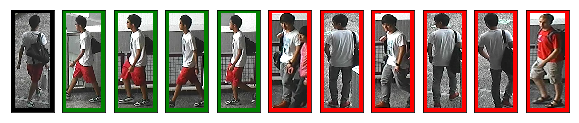

The ranklist for the 3th query image


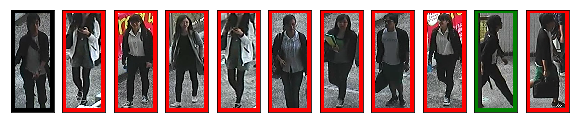

The ranklist for the 133th query image
Drawing the CMC curve of the model


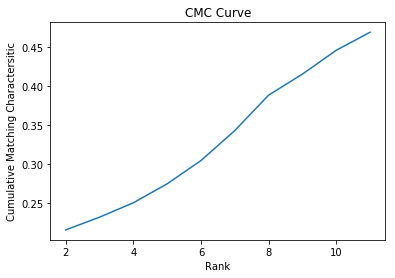

Mean average precision: 0.4356881570810142
Top1: 0.4692857142857143
Top5: 0.6714285714285714
Top10: 0.7492857142857143
Top5-Precision: 0.3428571428571429
Top5-Recall: 0.4509523809523809
Kmeans accuracy: 0.7192857142857143


In [29]:
MLKR_Model = MLKR(verbose=True).fit(train_feat_PCA_500,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat_PCA_500)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat_PCA_500)
print("PCA-MLKR with 500 dimensions")
kNN(query_feat_MLKR,gallery_feat_MLKR)

Test with original features

[MLKR]
[MLKR]  Iteration      Objective Value    Time(s)
[MLKR] ------------------------------------------
[MLKR]          0         2.116000e+03      28.00
[MLKR] Training took    30.12s.


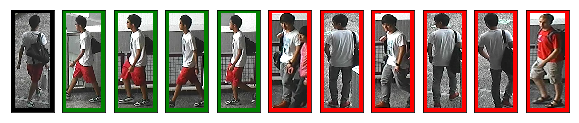

The ranklist for the 3th query image


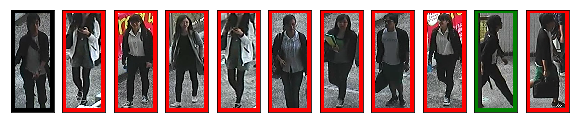

The ranklist for the 133th query image
Drawing the CMC curve of the model


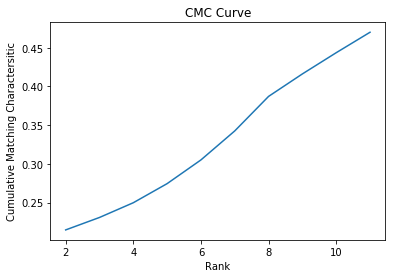

Mean average precision: 0.4353663677592249
Top1: 0.47
Top5: 0.6685714285714286
Top10: 0.7492857142857143
Top5-Precision: 0.3425714285714286
Top5-Recall: 0.4498214285714286
Kmeans accuracy: 0.7085714285714285


In [30]:
MLKR_Model = MLKR(verbose=True).fit(train_feat,train_labels)
query_feat_MLKR = MLKR_Model.transform(query_feat)
gallery_feat_MLKR = MLKR_Model.transform(gallery_feat)

kNN(query_feat_MLKR, gallery_feat_MLKR)

### Fully connected Neural Network with Triplet Loss

In [31]:
import tensorflow as tf

In [32]:
# define an auxiliary matrix for training
train_matrix = np.append(train_feat, np.reshape(train_labels, (7368,1)), axis=1)

<b> Define necessary triplet loss function

In [33]:
def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.

    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 0) - 2.0 * dot_product + tf.expand_dims(square_norm, 1)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances

def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask

def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.

    For each anchor, we get the hardest positive and hardest negative to form a triplet.

    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.

    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

<b> Create Neural Network

<b> Neural Network with activation function

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


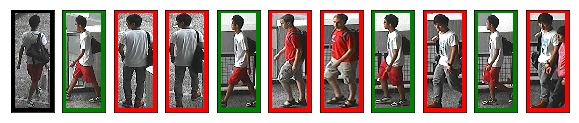

The ranklist for the 3th query image


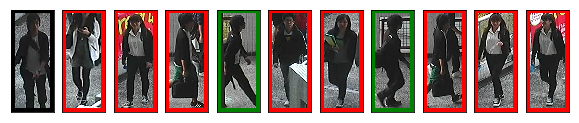

The ranklist for the 133th query image
Drawing the CMC curve of the model


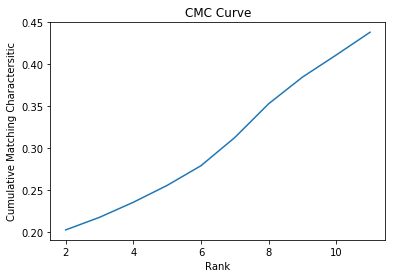

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return dista

Mean average precision: 0.39756367243867236
Top1: 0.43785714285714283
Top5: 0.635
Top10: 0.7307142857142858
Top5-Precision: 0.31228571428571433
Top5-Recall: 0.4105357142857143
Kmeans accuracy: 0.6907142857142857


/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [34]:
n_input = 2048   # input layer 
n_hidden1 = 1024 # 1st hidden layer
n_hidden2 = 512 # 2nd hidden layer
n_hidden3 = 256 #3rd hidden layer
n_output = 256   # output layer 

learning_rate = 1e-4
n_iterations = 10000
batch_person_size = 72
batch_image_size = 4
batch_size = batch_person_size * batch_image_size
dropout = 0.5

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None])
keep_prob = tf.placeholder(tf.float32) 

layer_1 = tf.layers.dense(X, n_hidden1, tf.nn.relu)
layer_norm_1 = tf.layers.batch_normalization(layer_1)
layer_drop_1 = tf.nn.dropout(layer_norm_1, keep_prob)
layer_2 = tf.layers.dense(layer_drop_1, n_hidden2)
layer_norm_2 = tf.layers.batch_normalization(layer_2) #layer not used for final selection
layer_3 = tf.layers.dense(layer_norm_2, n_hidden3) #layer not used for final selection
layer_drop_3 = tf.nn.dropout(layer_3, keep_prob) #layer not used for final selection
output_layer = tf.layers.dense(layer_2, n_output)

hard_triplet_loss = batch_hard_triplet_loss(Y, output_layer, 100)
train_step = tf.train.AdamOptimizer(1e-4).minimize(hard_triplet_loss)

features = output_layer

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

unique_id_train = np.unique(train_labels) #find all unique training IDs

# train on mini batches
for i in range(n_iterations):
    batch_x = np.zeros((batch_size,2048))
    batch_y = np.zeros(batch_size)
    np.random.shuffle(train_matrix)
    unique_id_NN = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),batch_person_size))] # pick 18 random unique training IDs, random.sample does not work on numpy array
    for j in range(batch_person_size):
        bool_idx_NN = train_matrix[:,2048] == unique_id_NN[j]
        batch_x[j*batch_image_size:(j+1)*batch_image_size,:] = train_matrix[bool_idx_NN,:2048][:batch_image_size,:]
        batch_y[j*batch_image_size:(j+1)*batch_image_size] = train_matrix[bool_idx_NN,2048][:batch_image_size]
        
        
    
    batch_x, batch_y = train_matrix[:batch_size,:2048],train_matrix[:batch_size,2048]
    sess.run(train_step, feed_dict={X: batch_x, Y: batch_y, keep_prob:dropout})

    if i%1000==0:
        print("Iteration", str(i))
        
gallery_feat_Neural = sess.run(features, feed_dict={X: gallery_feat, Y: gallery_labels, keep_prob:1.0})
query_feat_Neural = sess.run(features, feed_dict={X: query_feat, Y: query_labels, keep_prob:1.0})

kNN(query_feat_Neural, gallery_feat_Neural)


<b> Linear Neural Network without activation functions

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000


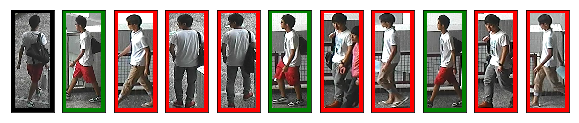

The ranklist for the 3th query image


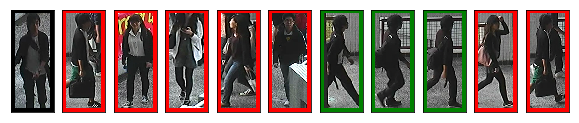

The ranklist for the 133th query image
Drawing the CMC curve of the model


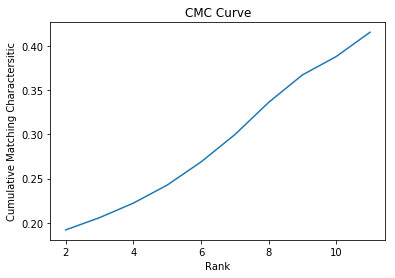

/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return dista

Mean average precision: 0.37539167182024324
Top1: 0.4157142857142857
Top5: 0.6257142857142857
Top10: 0.7107142857142857
Top5-Precision: 0.2997142857142857
Top5-Recall: 0.39369047619047615
Kmeans accuracy: 0.68


/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/Users/karolyhorvath/anaconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


In [35]:
n_input = 2048   # input layer
n_hidden1 = 1024 # 1st hidden layer
n_hidden2 = 512 # 2nd hidden layer
n_hidden3 = 512 #3rd hidden layer
n_output = 500   # output layer 

learning_rate = 1e-4
n_iterations = 5000
batch_person_size = 72
batch_image_size = 4
batch_size = batch_person_size * batch_image_size
dropout = 0.5

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None])
keep_prob = tf.placeholder(tf.float32) 

layer_1 = tf.layers.dense(X, n_hidden1)
layer_2 = tf.layers.dense(layer_1, n_hidden2)
layer_3 = tf.layers.dense(layer_2, n_hidden3) 
output_layer = tf.layers.dense(layer_3, n_output)

hard_triplet_loss = batch_hard_triplet_loss(Y, output_layer, 200)
train_step = tf.train.AdamOptimizer(1e-4).minimize(hard_triplet_loss)

features = output_layer

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

unique_id_train = np.unique(train_labels) #find all unique training IDs

# train on mini batches
for i in range(n_iterations):
    batch_x = np.zeros((batch_size,2048))
    batch_y = np.zeros(batch_size)
    np.random.shuffle(train_matrix)
    unique_id_NN = unique_id_train[np.array(random.sample(range(unique_id_train.shape[0]),batch_person_size))] # pick 18 random unique training IDs, random.sample does not work on numpy array
    for j in range(batch_person_size):
        bool_idx_NN = train_matrix[:,2048] == unique_id_NN[j]
        batch_x[j*batch_image_size:(j+1)*batch_image_size,:] = train_matrix[bool_idx_NN,:2048][:batch_image_size,:]
        batch_y[j*batch_image_size:(j+1)*batch_image_size] = train_matrix[bool_idx_NN,2048][:batch_image_size]
        
        
    
    batch_x, batch_y = train_matrix[:batch_size,:2048],train_matrix[:batch_size,2048]
    sess.run(train_step, feed_dict={X: batch_x, Y: batch_y, keep_prob:dropout})

    if i%1000==0:
        print("Iteration", str(i))
        
gallery_feat_Neural = sess.run(features, feed_dict={X: gallery_feat, Y: gallery_labels, keep_prob:1.0})
query_feat_Neural = sess.run(features, feed_dict={X: query_feat, Y: query_labels, keep_prob:1.0})

kNN(query_feat_Neural, gallery_feat_Neural)

### APPENDIX A: Demonstration of mAP calculation (with graphs)

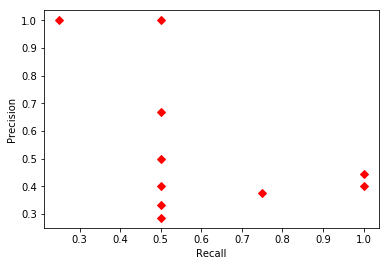

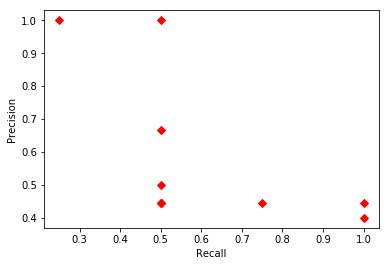

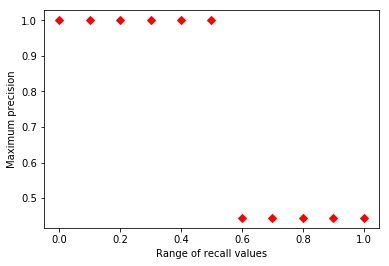

Average precision for index 1100 is:  0.7474747474747475
0.4353663677592249


In [37]:
# Average precision calculation demonstration
# Index 1100 is representative

# k nearest neighbours implementation without transforms

k = 10
top_k_rank = np.zeros((query_labels.shape[0],k))
top_k_precision = np.zeros((query_labels.shape[0],k))
top_k_recall = np.zeros((query_labels.shape[0],k))

nbrs = NearestNeighbors(n_neighbors=20).fit(gallery_feat)
distances, indices = nbrs.kneighbors(query_feat)

# Indices contains indices of the closes gallery pictures to each query image

# Select the images where camId and label not the same as of the query image
# Take top k of them

for i in range (0, query_labels.shape[0], 1):
    selected_indices = np.logical_not(np.logical_and(gallery_camId[indices[i, :]] == query_camId[i], gallery_labels[indices[i,:]] == query_labels[i]))
    number_of_removed = np.sum(np.logical_and(gallery_camId == query_camId[i], gallery_labels == query_labels[i]))
    removed_indices = indices [i, selected_indices]
    is_same_label = (query_labels[i] == gallery_labels[removed_indices])
    
    for j in range (0, k, 1):
        top_k_rank[i,j] = np.sum(is_same_label[:(j+1)]) != 0
        top_k_precision[i,j]=np.sum(is_same_label[:(j+1)])/(j+1)
        top_k_recall[i,j] = np.sum(is_same_label[:(j+1)])/(np.sum(gallery_labels==query_labels[i])-number_of_removed)

recall = top_k_recall[1100, :]
precision = top_k_precision[1100, :]

# Just plot the recall, precision values
plt.figure()
plt.plot(recall, precision, 'rD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Flat out the variation (not used in any calculations!)
index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
recall = recall[index]
precision = precision[index]
for i in range (0, recall.shape[0], 1):
    precision[i] = np.max(precision[:(i+1)])

plt.figure()
plt.plot(recall, precision, 'rD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Calculate the mean average precision values
recall = top_k_recall[1100, :]
precision = top_k_precision[1100, :]

index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
recall = recall[index]
precision = precision[index]
recall_range = np.arange(0, 1.1, 0.1)
precision_range = np.zeros((recall_range.shape))
for i in range (0, recall_range.shape[0], 1):
    if (precision[recall>=recall_range[i]].size != 0):
        precision_range[i] = np.max(precision[recall>=recall_range[i]])
    else:     
        precision_range[i] = 0

plt.figure()
plt.plot(recall_range, precision_range, 'rD')
plt.xlabel('Range of recall values')
plt.ylabel('Maximum precision')
plt.show()

ap = np.mean(precision_range)
print ("Average precision for index 1100 is: ", ap)

# Calculating mean average precision for the query set without any transformation applied

average_precisions = np.zeros((query_labels.shape))
for j in range (0, query_labels.shape[0], 1):
    recall = top_k_recall[j, :]
    precision = top_k_precision[j, :]
    index = (recall).argsort()[::-1] # argsort returns the indices that would sort an array (in this case the vector recall)
    recall = recall[index]
    precision = precision[index]
    recall_range = np.arange(0, 1.1, 0.1)
    precision_range = np.zeros((recall_range.shape))
    for i in range (0, recall_range.shape[0], 1):    
        if (precision[recall>=recall_range[i]].size != 0):
            precision_range[i] = np.max(precision[recall>=recall_range[i]])
        else:     
            precision_range[i] = 0
    average_precisions[j] = np.mean(precision_range)
print (average_precisions.mean())